
hello大家好，本文档将简单的为大家呈现我们pointNet模型的推理流程  

目录：  
1.打印/绘制模型  
2.推理操作的逐步展示（使用numpy实现）

首先是摘自train.py的模型各层的定义：

In [1]:

import os

import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.utils.data
import torch.nn.functional as F

import torch.nn.parallel
from torch.autograd import Variable
import numpy as np
import h5py
from tqdm import tqdm

# import provider
num_class = 10
total_epoch = 1 #30
# script_dir = os.path.dirname(__file__)  # 获取脚本所在的目录
script_dir = "./"

class STN3d(nn.Module):
    def __init__(self, channel):
        super(STN3d, self).__init__()
        self.conv1 = torch.nn.Conv1d(channel, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 9)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

    def forward(self, x):
        #print("            =========STN3d=========")
        #print("            before STN3d x:", x.size())

        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        #print("            x = F.relu(self.bn1(self.conv1(x))) x:", x.size())
            
        x = F.relu(self.bn2(self.conv2(x)))
        #print("            x = F.relu(self.bn2(self.conv2(x))) x:", x.size())

        x = F.relu(self.bn3(self.conv3(x)))
        #print("            x = F.relu(self.bn3(self.conv3(x))) x:", x.size())

        x = torch.max(x, 2, keepdim=True)[0]
        #print("            x = torch.max(x, 2, keepdim=True)[0] x:", x.size())

        x = x.view(-1, 1024)
        #print("            x = x.view(-1, 1024) x:", x.size())

        x = F.relu(self.bn4(self.fc1(x)))
        #print("            x = F.relu(self.bn4(self.fc1(x))) x:", x.size())
        x = F.relu(self.bn5(self.fc2(x)))
        #print("            x = F.relu(self.bn5(self.fc2(x))) x:", x.size())

        x = self.fc3(x)
        #print("            x = self.fc3(x) x:", x.size())

        iden = Variable(torch.from_numpy(np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32))).view(1, 9).repeat(
            batchsize, 1)
        #print("            iden = Variable(torch.from_numpy(np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32))).view(1, 9).repeat(batchsize, 1) iden:", iden.size())
        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        #print("            x = x + iden x:", x.size())

        x = x.view(-1, 3, 3)

        #print("            x = x.view(-1, 3, 3) x:", x.size())


        #print("            =========end STN3d=========")
        return x


class STNkd(nn.Module):
    def __init__(self, k=64):
        super(STNkd, self).__init__()
        self.conv1 = torch.nn.Conv1d(k, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k * k)
        self.relu = nn.ReLU()

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)

        self.k = k

    def forward(self, x):
        #print("            =========STNkd=========")
        #print("            before STNkd x:", x.size())

        batchsize = x.size()[0]
        x = F.relu(self.bn1(self.conv1(x)))
        #print("            x = F.relu(self.bn1(self.conv1(x))) x:", x.size())

        x = F.relu(self.bn2(self.conv2(x)))
        #print("            x = F.relu(self.bn2(self.conv2(x))) x:", x.size())

        x = F.relu(self.bn3(self.conv3(x)))
        #print("            x = F.relu(self.bn3(self.conv3(x))) x:", x.size())

        x = torch.max(x, 2, keepdim=True)[0]
        #print("            x = torch.max(x, 2, keepdim=True)[0] x:", x.size())

        x = x.view(-1, 1024)
        #print("            x = x.view(-1, 1024) x:", x.size())

        x = F.relu(self.bn4(self.fc1(x)))
        #print("            x = F.relu(self.bn4(self.fc1(x))) x:", x.size())

        x = F.relu(self.bn5(self.fc2(x)))
        #print("            x = F.relu(self.bn5(self.fc2(x))) x:", x.size())

        x = self.fc3(x)
        #print("            x = self.fc3(x) x:", x.size())

        iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1, self.k * self.k).repeat(
            batchsize, 1)
        #print("            iden = Variable(torch.from_numpy(np.eye(self.k).flatten().astype(np.float32))).view(1, self.k * self.k).repeat(batchsize, 1) iden:", iden.size())

        if x.is_cuda:
            iden = iden.cuda()
        x = x + iden
        #print("            x = x + iden x:", x.size())
        x = x.view(-1, self.k, self.k)

        #print("            x = x.view(-1, self.k, self.k)x:", x.size())

        #print("            =========end STNkd=========")

        return x


class PointNetEncoder(nn.Module):
    def __init__(self, global_feat=True, feature_transform=False, channel=3):
        super(PointNetEncoder, self).__init__()
        self.stn = STN3d(channel)
        self.conv1 = torch.nn.Conv1d(channel, 64, 1)
        self.conv2 = torch.nn.Conv1d(64, 128, 1)
        self.conv3 = torch.nn.Conv1d(128, 1024, 1)
        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.global_feat = global_feat
        self.feature_transform = feature_transform
        if self.feature_transform:
            self.fstn = STNkd(k=64)

    def forward(self, x):
        #print("    ============PointNetEncoder============")
        #print("    before PointNetEncoder:", x.size())

        B, D, N = x.size()
        trans = self.stn(x)
        #print("    trans = self.stn(x) trans:", trans.size())

        x = x.transpose(2, 1)
        #print("    x = x.transpose(2, 1) x:", x.size())

        if D > 3:
            feature = x[:, :, 3:]
            x = x[:, :, :3]
        x = torch.bmm(x, trans)
        #print("    x = torch.bmm(x, trans) x:", x.size())

        if D > 3:
            x = torch.cat([x, feature], dim=2)
        x = x.transpose(2, 1)
        #print("    x = x.transpose(2, 1) x:", x.size())
        x = F.relu(self.bn1(self.conv1(x)))
        #print("    x = F.relu(self.bn1(self.conv1(x))) x:", x.size())


        if self.feature_transform:
            #print("    =========self.feature_transform TRUE=========")
            trans_feat = self.fstn(x)
            #print("        trans_feat = self.fstn(x) trans_feat:", trans_feat.size())
            x = x.transpose(2, 1)
            #print("        x = x.transpose(2, 1) x:", x.size())
            x = torch.bmm(x, trans_feat)
            #print("        x = torch.bmm(x, trans_feat) x:", x.size())
            x = x.transpose(2, 1)
            #print("        x = x.transpose(2, 1) x:", x.size())
            #print("    =========end self.feature_transform TRUE=========")
        else:
            #print("    =========self.feature_transform FALSE=========")
            trans_feat = None
            #print("    =========end self.feature_transform FALSE=========")


        pointfeat = x
        x = F.relu(self.bn2(self.conv2(x)))
        #print("    x = F.relu(self.bn2(self.conv2(x))) x:", x.size())

        x = self.bn3(self.conv3(x))
        #print("    x = self.bn3(self.conv3(x)) x:", x.size())

        x = torch.max(x, 2, keepdim=True)[0]
        #print("    x = torch.max(x, 2, keepdim=True)[0] x:", x.size())

        x = x.view(-1, 1024)
        #print("    x = x.view(-1, 1024) x:", x.size())

        if self.global_feat:
            #print("    =========self.global_feat TRUE=========")
            #print("    =========end self.global_feat TRUE=========")
            return x, trans, trans_feat

        else:
            #print("    =========self.global_feat FALSE=========")
            x = x.view(-1, 1024, 1).repeat(1, 1, N)
            #print("        x = x.view(-1, 1024, 1).repeat(1, 1, N) x:", x.size())

            rnt = torch.cat([x, pointfeat], 1) #add
            #print("        return size x:", rnt.size())

            #print("    =========end self.global_feat FALSE=========")
            return torch.cat([x, pointfeat], 1), trans, trans_feat


def feature_transform_reguliarzer(trans):
    d = trans.size()[1]
    I = torch.eye(d)[None, :, :]
    if trans.is_cuda:
        I = I.cuda()
    loss = torch.mean(torch.norm(torch.bmm(trans, trans.transpose(2, 1)) - I, dim=(1, 2)))
    return loss


# 模型定义
class get_model(nn.Module):
    def __init__(self, k=10, normal_channel=False):
        super(get_model, self).__init__()
        if normal_channel:
            channel = 6
        else:
            channel = 3
        self.feat = PointNetEncoder(global_feat=True, feature_transform=True, channel=channel)
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, k)
        self.dropout = nn.Dropout(p=0.4)
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu = nn.ReLU()

    def forward(self, x):
        # x, trans, trans_feat = self.feat(x)
        # x = F.relu(self.bn1(self.fc1(x)))
        # x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        # x = self.fc3(x)
        # x = F.log_softmax(x, dim=1)
        # return x, trans_feat
        #print("============main model============")
        #print("type(x)",type(x))
        #print("before feat:", x.size())
        x, trans, trans_feat = self.feat(x)
        #print("After feat:", x.size())
        x = F.relu(self.bn1(self.fc1(x)))
        #print("After fc1:", x.size())
        x = F.relu(self.bn2(self.dropout(self.fc2(x))))
        #print("After fc2:", x.size())
        x = self.fc3(x)
        #print("After fc3:", x.size())
        x = F.log_softmax(x, dim=1)
        #print("After softmax:", x.size())
        #print("============end main model============")
        return x, trans_feat

class get_loss(torch.nn.Module):
    def __init__(self, mat_diff_loss_scale=0.001):
        super(get_loss, self).__init__()
        self.mat_diff_loss_scale = mat_diff_loss_scale

    def forward(self, pred, target, trans_feat):
        loss = F.nll_loss(pred, target)
        mat_diff_loss = feature_transform_reguliarzer(trans_feat)

        total_loss = loss + mat_diff_loss * self.mat_diff_loss_scale
        return total_loss


class PointCloudDataset(Dataset):
    def __init__(self,root, split):
        self.list_of_points = []
        self.list_of_labels = []
        self.root = root
        self.split = split

        # with h5py.File(f"{split}_point_clouds.h5","r") as hf:
        with h5py.File(f"{self.root}/{self.split}_point_clouds.h5","r") as hf:
            for k in hf.keys():
                self.list_of_points.append(hf[k]["points"][:].astype(np.float32))
                self.list_of_labels.append(hf[k].attrs["label"])
        self.fix_length_statistics_with_median()

    def __len__(self):
        return len(self.list_of_points)

    def __getitem__(self, idx):
        points = self.list_of_points[idx]
        label = self.list_of_labels[idx]
        return points, label

    def fix_length_statistics_with_median(self):
        lengths = [points.shape[0] for points in self.list_of_points]
        fix_length = int( np.median(lengths) )
        
        new_list_of_points = []
        for points in self.list_of_points:
            if(points.shape[0] >= fix_length):
                new_list_of_points.append(points[:fix_length, :])
            else:
                new_list_of_points.append(np.concatenate((points, np.zeros((fix_length - points.shape[0], 3), dtype=np.float32)), axis=0))
        self.list_of_points = new_list_of_points


def inplace_relu(m):
    classname = m.__class__.__name__
    if classname.find('ReLU') != -1:
        m.inplace=True


import time
def test(model, loader, num_class=10):

    # 计时
    start = time.time()

    mean_correct = []
    classifier = model.eval()

    # for j, (points, target) in tqdm(enumerate(loader), total=len(loader)):
    for j, (points, target) in enumerate(loader):

        points, target = points.to(device), target.to(device)

        points = points.transpose(2, 1)
        pred, _ = classifier(points)
        pred_choice = pred.data.max(1)[1]

        correct = pred_choice.eq(target.long().data).cpu().sum()
        # mean_correct.append(correct.item() / float(points.size()[0]))
        mean_correct.append(correct.item())

    # instance_acc = np.mean(mean_correct)
    instance_acc = np.sum(mean_correct) / len(loader.dataset)

    # 结束计时
    end = time.time()

    return instance_acc, end-start

def load_model_params_from_txt(model, directory):
    state_dict = model.state_dict()
    for name in state_dict.keys():
        file_path = os.path.join(directory, f'{name}.txt')
        if os.path.exists(file_path):
            param_data = np.loadtxt(file_path)
            param_data = torch.tensor(param_data).reshape(state_dict[name].shape)
            state_dict[name].copy_(param_data)
        else:
            print(f"Warning: {file_path} does not exist.")
    model.load_state_dict(state_dict)

def read_params(dir):
    # 列出所有txt文件
    files = [f for f in os.listdir(dir) if f.endswith('.txt')]
    params = {}
    for fileName in files:
        data = []
        with open(os.path.join(dir,fileName), 'r') as file:
            lines = file.readlines()
            for line in lines:
                line = line.strip()
                value = float(line)
                data.append(value)
        modelName = fileName.replace(".txt","")
        params[modelName] = data
    return params


使用torch框架对测试集进行推理（这里使用了国科大在线上给大家的默认参数）


In [2]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
data_path = './data'
test_dataset = PointCloudDataset(root=data_path, split='test') #注意，读取时对数据集的长度进行了填充/截取
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

torch.cuda.empty_cache()
classifier = get_model(num_class).to(device)
# classifier.load_state_dict(torch.load('best_model.pth'))
# 读取并加载模型参数
load_model_params_from_txt(classifier, script_dir)

instance_acc, test_time = test(classifier.eval(), test_dataloader, num_class)

print(f"{test_time:.4f}:{instance_acc:.4f}")

11.2182:0.1070


根据个人经验，了解一个模型、实现它的推理，首先需要清楚模型各层输入输出的尺寸。   
打印或者绘制模型来获取各层尺寸信息的方法有很多，下面列举了几种（也可以直接在模型类的forward方法下print打印，正如上面代码注释的print语句）：

points_tensor.size:  torch.Size([1, 3, 22500])


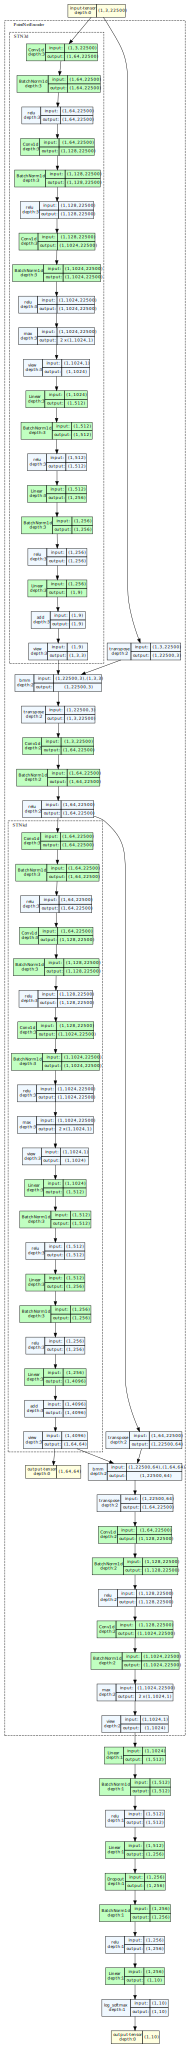

In [3]:
# 模型打印与绘制

# way1
# print(classifier)

# way2
# from torchsummary import summary
# summary(classifier, (3, 22500)) #会报错 或许是无法识别某些改尺寸的操作？

# way3
from torchviz import make_dot
id = 0
points = test_dataset.list_of_points[id]

points_tensor = torch.from_numpy(points.T)
points_tensor = points_tensor.unsqueeze(0)
print("points_tensor.size: ",points_tensor.size())
x = points_tensor.to(device)
y = classifier(x)[0]

# output = make_dot(y.mean(), params=dict(classifier.named_parameters()), show_attrs=True, show_saved=True)
# output.format = "png"
# output.directory = "."
# output.render("torchviz", view=False)

# way4 torchview 个人感觉比较直观
from torchview import draw_graph
model_graph = draw_graph(classifier, input_size=x.shape, expand_nested=True, save_graph=True, filename="torchview", directory=".")
model_graph.visual_graph

# way5 tensorwatch 可能是版本问题？ 报错AttributeError: module 'torch.onnx' has no attribute 'set_training'
# from tensorwatch import draw_model
# draw_model(classifier, x.shape)

借助pytorch的官方文档和网络搜索，我们能找到conv1d、batchnorm1d、relu、log_softmax等这些操作是如何对输入进行运算的，继而可以自己实现上述操作。下面是使用numpy库的逐步实现。

In [4]:
# 总 推理的逐步骤实现 batchsize=1 train.py中if语句没有执行到的操作都略过了 
# 助教实现，仅供参考，如有错误请联系纠正 

# 使用第一个点云数据
points = test_dataset.list_of_points[0]

# 读取模型参数
dir = "./cuda/" # 保存模型参数文件(.txt)的文件夹路径
params = read_params(dir)

# kernelsize=1, stride=1
# https://pytorch.org/docs/stable/generated/torch.nn.Conv1d.html
def conv1d(x,weight_name,bias_name,in_num,out_nun): 
    conv1_w = np.array(params[weight_name]).reshape(out_nun,in_num)
    conv1_b = np.array(params[bias_name]).reshape(out_nun,1)
    # print(conv1_w.shape,points.T.shape)
    conv1_res = conv1_w @ x + conv1_b
    return conv1_res

# 注意，推理时的归一化不是使用样本的均值和方差，而是使用保存下来的总体均值和方差进行
# https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html
# https://zhuanlan.zhihu.com/p/622644675#:~:text=%E5%9C%A8pytorch%E7%9A%84%E5%AE%98
# https://zhuanlan.zhihu.com/p/356500543
def bacthnorm1d(x,weight_name,bias_name,mean_name,var_name,num):
    x_mean = np.array(params[mean_name]).reshape(num,1)
    x_var  = np.array(params[var_name]).reshape(num,1)
    bn1_w = np.array(params[weight_name]).reshape(num,1)
    bn1_b = np.array(params[bias_name]).reshape(num,1)
    eps = 1e-5

    norm_res = (x - x_mean) / np.sqrt(x_var + eps)
    bn1_res = norm_res * bn1_w + bn1_b
    return bn1_res

# https://pytorch.org/docs/stable/generated/torch.nn.Linear.html
def linear(x,weight_name,bias_name,in_num,out_num):
    w = np.array(params[weight_name]).reshape(out_num,in_num)
    b = np.array(params[bias_name]).reshape(out_num,1)
    x = x.reshape(-1,1)
    y = w @ x + b
    return y.reshape(y.shape[0])

# ai give
def log_softmax(x):
    x = x.reshape(1,-1) #(batchsize,10)
    max_x = np.max(x, axis=1, keepdims=True)
    exp_x = np.exp(x - max_x)
    sum_exp_x = np.sum(exp_x, axis=1, keepdims=True)
    log_softmax_x = np.log(exp_x / sum_exp_x)

    return log_softmax_x.reshape(log_softmax_x.shape[1])


# ============main============

    # ============PointNetEncoder============

        # =========STN3d=========

# points : (22500,3)
feat_stn_conv1_res = conv1d(points.T,"feat.stn.conv1.weight","feat.stn.conv1.bias",3,64)
feat_stn_bn1_res = bacthnorm1d(feat_stn_conv1_res,"feat.stn.bn1.weight","feat.stn.bn1.bias","feat.stn.bn1.running_mean","feat.stn.bn1.running_var",64)
feat_stn_relu_bn1_res = np.where(feat_stn_bn1_res>0,feat_stn_bn1_res,0)

feat_stn_conv2_res = conv1d(feat_stn_relu_bn1_res,"feat.stn.conv2.weight","feat.stn.conv2.bias",64,128)
feat_stn_bn2_res = bacthnorm1d(feat_stn_conv2_res,"feat.stn.bn2.weight","feat.stn.bn2.bias","feat.stn.bn2.running_mean","feat.stn.bn2.running_var",128)
feat_stn_relu_bn2_res = np.where(feat_stn_bn2_res>0,feat_stn_bn2_res,0)

feat_stn_conv3_res = conv1d(feat_stn_relu_bn2_res,"feat.stn.conv3.weight","feat.stn.conv3.bias",128,1024)
feat_stn_bn3_res = bacthnorm1d(feat_stn_conv3_res,"feat.stn.bn3.weight","feat.stn.bn3.bias","feat.stn.bn3.running_mean","feat.stn.bn3.running_var",1024)
feat_stn_relu_bn3_res = np.where(feat_stn_bn3_res>0,feat_stn_bn3_res,0)

feat_stn_max_res = np.max(feat_stn_relu_bn3_res,axis=1)

feat_stn_fc1_res = linear(feat_stn_max_res,"feat.stn.fc1.weight","feat.stn.fc1.bias",1024,512)
feat_stn_bn4_res = bacthnorm1d(feat_stn_fc1_res.reshape(-1,1),"feat.stn.bn4.weight","feat.stn.bn4.bias","feat.stn.bn4.running_mean","feat.stn.bn4.running_var",512)
feat_stn_relu_bn4_res = np.where(feat_stn_bn4_res>0,feat_stn_bn4_res,0)

feat_stn_fc2_res = linear(feat_stn_relu_bn4_res,"feat.stn.fc2.weight","feat.stn.fc2.bias",512,256)
feat_stn_bn5_res = bacthnorm1d(feat_stn_fc2_res.reshape(-1,1),"feat.stn.bn5.weight","feat.stn.bn5.bias","feat.stn.bn5.running_mean","feat.stn.bn5.running_var",256)
feat_stn_relu_bn5_res = np.where(feat_stn_bn5_res>0,feat_stn_bn5_res,0)

feat_stn_fc3_res = linear(feat_stn_relu_bn5_res,"feat.stn.fc3.weight","feat.stn.fc3.bias",256,9)

feat_stn_iden = np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32)
feat_stn_res = feat_stn_fc3_res + feat_stn_iden
feat_stn_res = feat_stn_res.reshape(3,3)

        # =========end STN3d=========

trans = feat_stn_res
# points : (22500,3)
# trans : (3,3)
feat_bmm_res = points @ trans #torch.bmm, 批矩阵乘法（batch matrix multiplication）

feat_conv1_res = conv1d(feat_bmm_res.T,"feat.conv1.weight","feat.conv1.bias",3,64)
feat_bn1_res = bacthnorm1d(feat_conv1_res,"feat.bn1.weight","feat.bn1.bias","feat.bn1.running_mean","feat.bn1.running_var",64)
feat_relu_bn1_res = np.where(feat_bn1_res>0,feat_bn1_res,0)

        # =========STNkd=========
# print(f"feat_relu_bn1_res:{feat_relu_bn1_res.shape}") #(64, 22500)

feat_fstn_conv1_res = conv1d(feat_relu_bn1_res,"feat.fstn.conv1.weight","feat.fstn.conv1.bias",64,64)
feat_fstn_bn1_res = bacthnorm1d(feat_fstn_conv1_res,"feat.fstn.bn1.weight","feat.fstn.bn1.bias","feat.fstn.bn1.running_mean","feat.fstn.bn1.running_var",64)
feat_fstn_relu_bn1_res = np.where(feat_fstn_bn1_res>0,feat_fstn_bn1_res,0)

feat_fstn_conv2_res = conv1d(feat_fstn_relu_bn1_res,"feat.fstn.conv2.weight","feat.fstn.conv2.bias",64,128)
feat_fstn_bn2_res = bacthnorm1d(feat_fstn_conv2_res,"feat.fstn.bn2.weight","feat.fstn.bn2.bias","feat.fstn.bn2.running_mean","feat.fstn.bn2.running_var",128)
feat_fstn_relu_bn2_res = np.where(feat_fstn_bn2_res>0,feat_fstn_bn2_res,0)

feat_fstn_conv3_res = conv1d(feat_fstn_relu_bn2_res,"feat.fstn.conv3.weight","feat.fstn.conv3.bias",128,1024)
feat_fstn_bn3_res = bacthnorm1d(feat_fstn_conv3_res,"feat.fstn.bn3.weight","feat.fstn.bn3.bias","feat.fstn.bn3.running_mean","feat.fstn.bn3.running_var",1024)
feat_fstn_relu_bn3_res = np.where(feat_fstn_bn3_res>0,feat_fstn_bn3_res,0)

feat_fstn_max_res = np.max(feat_fstn_relu_bn3_res,axis=1)

feat_fstn_fc1_res = linear(feat_fstn_max_res,"feat.fstn.fc1.weight","feat.fstn.fc1.bias",1024,512)
feat_fstn_bn4_res = bacthnorm1d(feat_fstn_fc1_res.reshape(-1,1),"feat.fstn.bn4.weight","feat.fstn.bn4.bias","feat.fstn.bn4.running_mean","feat.fstn.bn4.running_var",512)
feat_fstn_relu_bn4_res = np.where(feat_fstn_bn4_res>0,feat_fstn_bn4_res,0)

feat_fstn_fc2_res = linear(feat_fstn_relu_bn4_res,"feat.fstn.fc2.weight","feat.fstn.fc2.bias",512,256)
feat_fstn_bn5_res = bacthnorm1d(feat_fstn_fc2_res.reshape(-1,1),"feat.fstn.bn5.weight","feat.fstn.bn5.bias","feat.fstn.bn5.running_mean","feat.fstn.bn5.running_var",256)
feat_fstn_relu_bn5_res = np.where(feat_fstn_bn5_res>0,feat_fstn_bn5_res,0)

feat_fstn_fc3_res = linear(feat_fstn_relu_bn5_res,"feat.fstn.fc3.weight","feat.fstn.fc3.bias",256,64*64)

feat_fstn_iden = np.eye(64).flatten().astype(np.float32)
feat_fstn_res = feat_fstn_fc3_res + feat_fstn_iden
feat_fstn_res = feat_fstn_res.reshape(64,64)

trans_feat = feat_fstn_res

        # =========end STNkd=========

# print(feat_relu_bn1_res.T.shape,trans_feat.shape)
feat_bmm_res2 = feat_relu_bn1_res.T @ trans_feat

feat_conv2_res = conv1d(feat_bmm_res2.T, "feat.conv2.weight","feat.conv2.bias",64,128)
feat_bn2_res = bacthnorm1d(feat_conv2_res,"feat.bn2.weight","feat.bn2.bias","feat.bn2.running_mean","feat.bn2.running_var",128)
feat_relu_bn2_res = np.where(feat_bn2_res>0,feat_bn2_res,0)

feat_conv3_res = conv1d(feat_relu_bn2_res,"feat.conv3.weight","feat.conv3.bias",128,1024)
feat_bn3_res = bacthnorm1d(feat_conv3_res,"feat.bn3.weight","feat.bn3.bias","feat.bn3.running_mean","feat.bn3.running_var",1024)

feat_max_res = np.max(feat_bn3_res,axis=1)

    # ============end PointNetEncoder============

# print(feat_max_res.shape)
fc1_res = linear(feat_max_res,"fc1.weight","fc1.bias",1024,512)
bn1_res = bacthnorm1d(fc1_res.reshape(-1,1),"bn1.weight","bn1.bias","bn1.running_mean","bn1.running_var",512)
relu_bn1_res = np.where(bn1_res>0,bn1_res,0)

fc2_res = linear(relu_bn1_res,"fc2.weight","fc2.bias",512,256)
bn2_res = bacthnorm1d(fc2_res.reshape(-1,1),"bn2.weight","bn2.bias","bn2.running_mean","bn2.running_var",256)
relu_bn2_res = np.where(bn2_res>0,bn2_res,0) # eval()推理会关闭dropout，不用实现

fc3_res = linear(relu_bn2_res,"fc3.weight","fc3.bias",256,10)

softmax_res = log_softmax(fc3_res)

# ============end main============

print(softmax_res)
print(np.argmax(softmax_res))


[-1.29285860e+01 -1.02073274e+01 -9.82190798e+00 -5.95006973e+00
 -1.09899800e+01 -8.59973788e+00 -1.12080439e+01 -3.27927253e-03
 -1.03538251e+01 -8.02186619e+00]
7


In [5]:
# 和torch的推理结果进行对比

points = test_dataset.list_of_points[0]

points_tensor = torch.from_numpy(points.T)
points_tensor = points_tensor.unsqueeze(0)
print("points_tensor.size: ",points_tensor.size())
points_tensor_gpu = points_tensor.to(device)

res = classifier(points_tensor_gpu)
print(res[0])
test_res = torch.argmax(res[0])
print(f"numpy test label:{np.argmax(softmax_res)} -- torch test label:{test_res} -- real label:{test_dataset.list_of_labels[id]}")

mae_loss = nn.L1Loss()(torch.from_numpy(softmax_res.reshape(1,-1)), res[0].cpu()) #平均绝对误差 (MAE)
mae_loss

points_tensor.size:  torch.Size([1, 3, 22500])
tensor([[-2.2884, -2.3415, -2.3117, -2.2410, -2.3469, -2.3678, -2.2898, -2.2564,
         -2.2817, -2.3080]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
numpy test label:7 -- torch test label:3 -- real label:7


tensor(6.9558, dtype=torch.float64, grad_fn=<MeanBackward0>)

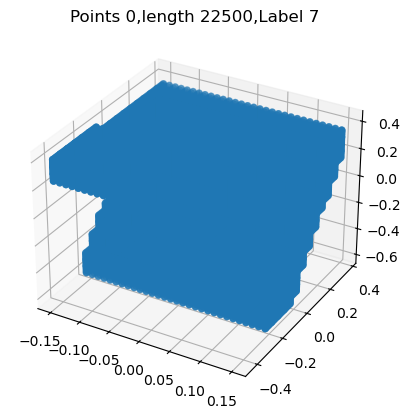

In [6]:
# 将点云画出来

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# points 是一个形状为 (N, 3) 的 NumPy 数组
# points = np.array([[x1, y1, z1],
#                    [x2, y2, z2],
#                    ...,
#                    [xN, yN, zN]])

point_id = 0
points = test_dataset.list_of_points[point_id]

# 创建一个新的图形
fig = plt.figure()
# 创建一个 3D 轴
ax = fig.add_subplot(111, projection='3d')

# 在图上绘制点
xs = points[:, 0]
ys = points[:, 1]
zs = points[:, 2]
ax.scatter(xs, ys, zs)

ax.set_title(f"Points {point_id},length {len(test_dataset.list_of_points[point_id])},Label {test_dataset.list_of_labels[point_id]}")

# 显示图形
plt.show()

In [7]:
# 使用逐步实现的代码对整个测试集进行推理(cpu)

list_test_label = []
num_real = 0
for i,points in tqdm(enumerate(test_dataset.list_of_points),total=len(test_dataset.list_of_points)):

    # ============main============

        # ============PointNetEncoder============

            # =========STN3d=========

    # points : (22500,3)
    feat_stn_conv1_res = conv1d(points.T,"feat.stn.conv1.weight","feat.stn.conv1.bias",3,64)
    feat_stn_bn1_res = bacthnorm1d(feat_stn_conv1_res,"feat.stn.bn1.weight","feat.stn.bn1.bias","feat.stn.bn1.running_mean","feat.stn.bn1.running_var",64)
    feat_stn_relu_bn1_res = np.where(feat_stn_bn1_res>0,feat_stn_bn1_res,0)

    feat_stn_conv2_res = conv1d(feat_stn_relu_bn1_res,"feat.stn.conv2.weight","feat.stn.conv2.bias",64,128)
    feat_stn_bn2_res = bacthnorm1d(feat_stn_conv2_res,"feat.stn.bn2.weight","feat.stn.bn2.bias","feat.stn.bn2.running_mean","feat.stn.bn2.running_var",128)
    feat_stn_relu_bn2_res = np.where(feat_stn_bn2_res>0,feat_stn_bn2_res,0)

    feat_stn_conv3_res = conv1d(feat_stn_relu_bn2_res,"feat.stn.conv3.weight","feat.stn.conv3.bias",128,1024)
    feat_stn_bn3_res = bacthnorm1d(feat_stn_conv3_res,"feat.stn.bn3.weight","feat.stn.bn3.bias","feat.stn.bn3.running_mean","feat.stn.bn3.running_var",1024)
    feat_stn_relu_bn3_res = np.where(feat_stn_bn3_res>0,feat_stn_bn3_res,0)

    feat_stn_max_res = np.max(feat_stn_relu_bn3_res,axis=1)
    # max_res.shape

    feat_stn_fc1_res = linear(feat_stn_max_res,"feat.stn.fc1.weight","feat.stn.fc1.bias",1024,512)
    feat_stn_bn4_res = bacthnorm1d(feat_stn_fc1_res.reshape(-1,1),"feat.stn.bn4.weight","feat.stn.bn4.bias","feat.stn.bn4.running_mean","feat.stn.bn4.running_var",512)
    feat_stn_relu_bn4_res = np.where(feat_stn_bn4_res>0,feat_stn_bn4_res,0)

    feat_stn_fc2_res = linear(feat_stn_relu_bn4_res,"feat.stn.fc2.weight","feat.stn.fc2.bias",512,256)
    feat_stn_bn5_res = bacthnorm1d(feat_stn_fc2_res.reshape(-1,1),"feat.stn.bn5.weight","feat.stn.bn5.bias","feat.stn.bn5.running_mean","feat.stn.bn5.running_var",256)
    feat_stn_relu_bn5_res = np.where(feat_stn_bn5_res>0,feat_stn_bn5_res,0)

    feat_stn_fc3_res = linear(feat_stn_relu_bn5_res,"feat.stn.fc3.weight","feat.stn.fc3.bias",256,9)

    feat_stn_iden = np.array([1, 0, 0, 0, 1, 0, 0, 0, 1]).astype(np.float32)
    feat_stn_res = feat_stn_fc3_res + feat_stn_iden
    feat_stn_res = feat_stn_res.reshape(3,3)

            # =========end STN3d=========

    trans = feat_stn_res
    # points : (22500,3)
    # trans : (3,3)
    feat_bmm_res = points @ trans #torch.bmm, 批矩阵乘法（batch matrix multiplication）

    feat_conv1_res = conv1d(feat_bmm_res.T,"feat.conv1.weight","feat.conv1.bias",3,64)
    feat_bn1_res = bacthnorm1d(feat_conv1_res,"feat.bn1.weight","feat.bn1.bias","feat.bn1.running_mean","feat.bn1.running_var",64)
    feat_relu_bn1_res = np.where(feat_bn1_res>0,feat_bn1_res,0)

            # =========STNkd=========
    # print(f"feat_relu_bn1_res:{feat_relu_bn1_res.shape}") #(64, 22500)

    feat_fstn_conv1_res = conv1d(feat_relu_bn1_res,"feat.fstn.conv1.weight","feat.fstn.conv1.bias",64,64)
    feat_fstn_bn1_res = bacthnorm1d(feat_fstn_conv1_res,"feat.fstn.bn1.weight","feat.fstn.bn1.bias","feat.fstn.bn1.running_mean","feat.fstn.bn1.running_var",64)
    feat_fstn_relu_bn1_res = np.where(feat_fstn_bn1_res>0,feat_fstn_bn1_res,0)

    feat_fstn_conv2_res = conv1d(feat_fstn_relu_bn1_res,"feat.fstn.conv2.weight","feat.fstn.conv2.bias",64,128)
    feat_fstn_bn2_res = bacthnorm1d(feat_fstn_conv2_res,"feat.fstn.bn2.weight","feat.fstn.bn2.bias","feat.fstn.bn2.running_mean","feat.fstn.bn2.running_var",128)
    feat_fstn_relu_bn2_res = np.where(feat_fstn_bn2_res>0,feat_fstn_bn2_res,0)

    feat_fstn_conv3_res = conv1d(feat_fstn_relu_bn2_res,"feat.fstn.conv3.weight","feat.fstn.conv3.bias",128,1024)
    feat_fstn_bn3_res = bacthnorm1d(feat_fstn_conv3_res,"feat.fstn.bn3.weight","feat.fstn.bn3.bias","feat.fstn.bn3.running_mean","feat.fstn.bn3.running_var",1024)
    feat_fstn_relu_bn3_res = np.where(feat_fstn_bn3_res>0,feat_fstn_bn3_res,0)

    feat_fstn_max_res = np.max(feat_fstn_relu_bn3_res,axis=1)

    feat_fstn_fc1_res = linear(feat_fstn_max_res,"feat.fstn.fc1.weight","feat.fstn.fc1.bias",1024,512)
    feat_fstn_bn4_res = bacthnorm1d(feat_fstn_fc1_res.reshape(-1,1),"feat.fstn.bn4.weight","feat.fstn.bn4.bias","feat.fstn.bn4.running_mean","feat.fstn.bn4.running_var",512)
    feat_fstn_relu_bn4_res = np.where(feat_fstn_bn4_res>0,feat_fstn_bn4_res,0)

    feat_fstn_fc2_res = linear(feat_fstn_relu_bn4_res,"feat.fstn.fc2.weight","feat.fstn.fc2.bias",512,256)
    feat_fstn_bn5_res = bacthnorm1d(feat_fstn_fc2_res.reshape(-1,1),"feat.fstn.bn5.weight","feat.fstn.bn5.bias","feat.fstn.bn5.running_mean","feat.fstn.bn5.running_var",256)
    feat_fstn_relu_bn5_res = np.where(feat_fstn_bn5_res>0,feat_fstn_bn5_res,0)

    feat_fstn_fc3_res = linear(feat_fstn_relu_bn5_res,"feat.fstn.fc3.weight","feat.fstn.fc3.bias",256,64*64)

    feat_fstn_iden = np.eye(64).flatten().astype(np.float32)
    feat_fstn_res = feat_fstn_fc3_res + feat_fstn_iden
    feat_fstn_res = feat_fstn_res.reshape(64,64)

    trans_feat = feat_fstn_res

            # =========end STNkd=========

    # print(feat_relu_bn1_res.T.shape,trans_feat.shape)
    feat_bmm_res2 = feat_relu_bn1_res.T @ trans_feat

    feat_conv2_res = conv1d(feat_bmm_res2.T, "feat.conv2.weight","feat.conv2.bias",64,128)
    feat_bn2_res = bacthnorm1d(feat_conv2_res,"feat.bn2.weight","feat.bn2.bias","feat.bn2.running_mean","feat.bn2.running_var",128)
    feat_relu_bn2_res = np.where(feat_bn2_res>0,feat_bn2_res,0)

    feat_conv3_res = conv1d(feat_relu_bn2_res,"feat.conv3.weight","feat.conv3.bias",128,1024)
    feat_bn3_res = bacthnorm1d(feat_conv3_res,"feat.bn3.weight","feat.bn3.bias","feat.bn3.running_mean","feat.bn3.running_var",1024)

    feat_max_res = np.max(feat_bn3_res,axis=1)

        # ============end PointNetEncoder============

    # print(feat_max_res.shape)
    fc1_res = linear(feat_max_res,"fc1.weight","fc1.bias",1024,512)
    bn1_res = bacthnorm1d(fc1_res.reshape(-1,1),"bn1.weight","bn1.bias","bn1.running_mean","bn1.running_var",512)
    relu_bn1_res = np.where(bn1_res>0,bn1_res,0)

    fc2_res = linear(relu_bn1_res,"fc2.weight","fc2.bias",512,256)
    bn2_res = bacthnorm1d(fc2_res.reshape(-1,1),"bn2.weight","bn2.bias","bn2.running_mean","bn2.running_var",256)
    relu_bn2_res = np.where(bn2_res>0,bn2_res,0) #!!!需要dropout

    fc3_res = linear(relu_bn2_res,"fc3.weight","fc3.bias",256,10)

    softmax_res = log_softmax(fc3_res) #reshape成为(batchsize,10)

    # ============end main============
    test_label = np.argmax(softmax_res)
    list_test_label.append(test_label)

    real_label = test_dataset.list_of_labels[i]

    if(test_label==real_label):
        num_real += 1
    # print(f"acc rate:{num_real}/{i+1}")
print(f"acc rate:{num_real}/{len(test_dataset.list_of_labels)}={num_real/len(test_dataset.list_of_labels)}")

  0%|          | 0/1000 [00:18<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
print(f"acc rate:{num_real}/{len(test_dataset.list_of_labels)}={num_real/len(test_dataset.list_of_labels)}")

acc rate:855/1000=0.855


谢谢观看